# 네이버 영화리뷰 감성분석 도전하기

## Step1. 데이터 준비와 확인

In [1]:
# 필요한 모듈 import 및 라이브러리 버전 확인
import os
import tensorflow as tf
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Step 2. 데이터로더 구성
- nsmc 데이터셋은 전혀 가공되지 않은 텍스트파일로 이루어져 있으므로 가공이 필요하다.

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거 및 NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

- drop_duplicates(subset=['document'], inplace=True) : 'document'열에서 중복값을 검사해서 중복되는 행 제거한다. + 원본 변경한다.  
- tokenizer.morphs(sentence) : sentence에서 형태소 토큰화(한국어 특성상 영어의 어절 토큰화와 다르게 적용된다.)  
- np.concatenate(X_train).tolist() : X_train의 list를 합친 후 list형태로 반환

In [4]:
# 사전 index_to_word 구성
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## Step 3. 모델 구성을 위한 데이터 분석 및 가공

In [6]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# 적절한 최대 문장 길이 지정 및 패딩 추가
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='post', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[""],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


-------

## (1) RNN 모델

## Step 4. 모델 구성 및 validation set 구성

In [8]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수는 16 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM사용. LSTM state 벡터의 차원수는 8.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 15000건 분리
X_val = X_train[:15000]   
y_val = y_train[:15000]

# validation set을 제외한 나머지는 train set
partial_X_train = X_train[15000:]  
partial_y_train = y_train[15000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(131182, 41)
(131182,)


## Step 5. 모델 훈련 개시

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_pre = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 5s 7ms/step - loss: 0.5107 - accuracy: 0.7427 - val_loss: 0.3699 - val_accuracy: 0.8417
Epoch 2/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3431 - accuracy: 0.8562 - val_loss: 0.3471 - val_accuracy: 0.8502
Epoch 3/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3201 - accuracy: 0.8661 - val_loss: 0.3475 - val_accuracy: 0.8490
Epoch 4/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3103 - accuracy: 0.8701 - val_loss: 0.3551 - val_accuracy: 0.8501
Epoch 5/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3043 - accuracy: 0.8726 - val_loss: 0.3649 - val_accuracy: 0.8377
Epoch 6/20
257/257 [==============================] - 1s 5ms/step - loss: 0.2982 - accuracy: 0.8748 - val_loss: 0.3447 - val_accuracy: 0.8516
Epoch 7/20
257/257 [==============================] - 1s 5ms/step - loss: 0.2905 - accuracy: 0.8785 - val_loss: 0.3546 - val_accuracy: 0.8469
Epoch 

In [11]:
# 테스트셋으로 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4501 - accuracy: 0.8384
[0.45010116696357727, 0.838395357131958]


In [12]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict_pre = history_pre.history
print(history_dict_pre.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Step 6. Loss, Accuracy 그래프 시각화

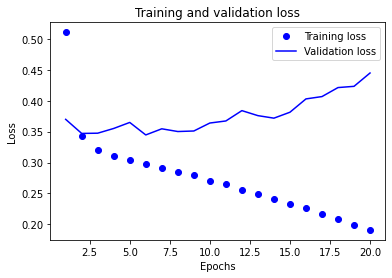

In [13]:
# loss 그래프로 그려보기
import matplotlib.pyplot as plt

acc = history_dict_pre['accuracy']
val_acc = history_dict_pre['val_accuracy']
loss = history_dict_pre['loss']
val_loss = history_dict_pre['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

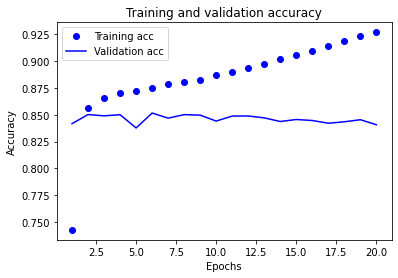

In [14]:
# accuracy 그래프로 그려보기
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 7. 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [16]:
# 학습된 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
 # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
# Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([ 0.0051451 ,  0.03420222, -0.00779674,  0.01284155,  0.05805212,
       -0.04627453,  0.08307851, -0.00420318,  0.03599301, -0.03558807,
        0.08093625,  0.02495336,  0.00929612, -0.03749272, -0.142584  ,
       -0.04832   ], dtype=float32)

In [18]:
# '재미'와 유사한 단어 찾아보기
word_vectors.similar_by_word('재미')

[('너무나', 0.9239725470542908),
 ('이렇게', 0.8974748253822327),
 ('정말', 0.878810465335846),
 ('가장', 0.8785668611526489),
 ('매우', 0.8771823048591614),
 ('제대로', 0.8740683197975159),
 ('완전', 0.8663330674171448),
 ('더더욱', 0.8473678827285767),
 ('모두', 0.8441237211227417),
 ('몰입', 0.8374240398406982)]

## Step 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [19]:
# Word2Vec 모델 가져오기
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['연기']
vector

array([-2.0634167e+00, -1.9734977e-01, -3.7762792e+00, -5.3865463e-01,
        2.3210046e+00,  5.0277454e-01, -2.6870925e+00, -3.6405969e+00,
       -1.0963349e+00,  2.5664790e+00, -5.1018113e-01,  8.3338451e-01,
       -1.8663673e+00, -3.2897377e+00,  1.9831001e+00,  1.6336359e+00,
        4.4046003e-01, -2.4318197e+00,  2.8961849e+00,  2.4294887e+00,
       -2.0216727e+00,  3.0315948e+00,  3.3207154e+00, -2.4021013e+00,
       -2.1328015e+00, -1.4202063e-01, -1.0130103e+00,  1.1087272e+00,
        1.5143281e-01, -1.2870296e+00, -1.9356625e+00, -2.6313615e-01,
        1.2828869e+00,  7.1148652e-01, -2.7823136e+00,  2.2900889e+00,
       -2.6714947e+00,  1.3707482e+00, -1.3911188e+00,  3.1011790e-01,
        2.4304125e-01, -1.4502478e+00,  2.9619246e+00,  1.5410364e+00,
       -1.8164583e+00, -1.1160779e+00,  3.2429931e+00, -1.1567547e-01,
        4.9492879e+00, -3.1496325e+00, -8.0028749e-01, -2.4726155e+00,
        2.0556252e+00, -3.3037343e+00, -1.1217453e+00, -1.3909938e+00,
      

- 파일을 불러오는 경로를 처음에 '/aiffel/sentiment_classification/data/word2vec_ko.model'로 설정해서 구글링도 해보면서 ko.bin 파일도 받아봤는데 zip이 안풀려서 어떻게 할 수가 없었다. 그렇게 이곳저곳에서 정보를 찾아보다가 경로가 '/aiffel/sentiment_classification/data/word2vec_ko.model'가 아니라 '/data/word2vec_ko.model였다. 경로설정을 잘하고나니까 error없이 잘 해결되었다. 경로 설정시 다시 한 번 신경써서 봐야겠다.

In [20]:
# '재미'와 유사한 단어 찾아보기
word_vectors.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

- 위에서 error를 해결하자마자 다시 바로 error를 해결해야했다. 한국어 Word2Vec에서는 모델을 활용할 때 .wv를 붙여서 활용한다는 말을 보고 시도해봤는데 다행히 바로 해결할 수 있었다.

In [21]:
# 학습했던 모델의 임베딩 레이어를 word_vectors의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [22]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1025/1025 [==============================] - 6s 5ms/step - loss: 0.5297 - accuracy: 0.7277 - val_loss: 0.4274 - val_accuracy: 0.8052
Epoch 2/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3895 - accuracy: 0.8254 - val_loss: 0.3717 - val_accuracy: 0.8333
Epoch 3/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3398 - accuracy: 0.8524 - val_loss: 0.3493 - val_accuracy: 0.8447
Epoch 4/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3122 - accuracy: 0.8680 - val_loss: 0.3412 - val_accuracy: 0.8521
Epoch 5/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2930 - accuracy: 0.8776 - val_loss: 0.3410 - val_accuracy: 0.8514
Epoch 6/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2768 - accuracy: 0.8853 - val_loss: 0.3438 - val_accuracy: 0.8487
Epoch 7/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2609 - accuracy: 0.8932 - val_loss: 0.3481 - val_accuracy:

In [24]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5947 - accuracy: 0.8354
[0.5947375297546387, 0.8353642225265503]


- RNN 모델의 경우 convolution layer와 epoch, batch size를 조절봤지만 accuracy가 0.82~0.84사이로 word2vec을 하기 전, 후 차이가 크게 없었다.

-------

## (2) CNN 모델

## Step 4. 모델 구성 및 validation set 구성

In [33]:
vocab_size = 10000 # 어휘 사전의 크기(10000개 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) # (커널 개수, 커널크기, 활성화함수)
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [34]:
# validation set 30000건 분리
X_val_cnn = X_train[:30000]   
y_val_cnn = y_train[:30000]

# validation set을 제외한 나머지는 train set
partial_X_train_cnn = X_train[30000:]  
partial_y_train_cnn = y_train[30000:]

print(partial_X_train_cnn.shape)
print(partial_y_train_cnn.shape)

(116182, 41)
(116182,)


## Step 5. 모델 훈련 개시

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_cnn_pre = model.fit(partial_X_train_cnn,
                    partial_y_train_cnn,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_cnn, y_val_cnn),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 6ms/step - loss: 0.4852 - accuracy: 0.7630 - val_loss: 0.3578 - val_accuracy: 0.8436
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3306 - accuracy: 0.8604 - val_loss: 0.3450 - val_accuracy: 0.8495
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2957 - accuracy: 0.8784 - val_loss: 0.3392 - val_accuracy: 0.8535
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8936 - val_loss: 0.3443 - val_accuracy: 0.8537
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2342 - accuracy: 0.9099 - val_loss: 0.3571 - val_accuracy: 0.8520
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2001 - accuracy: 0.9259 - val_loss: 0.3776 - val_accuracy: 0.8510
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1660 - accuracy: 0.9415 - val_loss: 0.4146 - val_accuracy: 0.8475
Epoch 

In [36]:
# 테스트셋으로 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9852 - accuracy: 0.8163
[0.9851579070091248, 0.8162621855735779]


In [37]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict_cnn_pre = history_cnn_pre.history
print(history_dict_cnn_pre.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Step 6. Loss, Accuracy 그래프 시각화

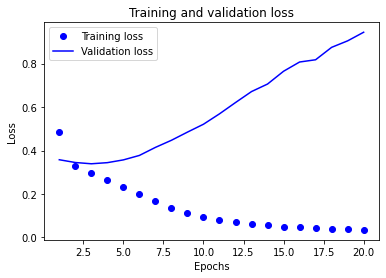

In [38]:
# loss 그래프로 그려보기
acc2 = history_dict_cnn_pre['accuracy']
val_acc2 = history_dict_cnn_pre['val_accuracy']
loss2 = history_dict_cnn_pre['loss']
val_loss2 = history_dict_cnn_pre['val_loss']

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, loss2, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss2, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

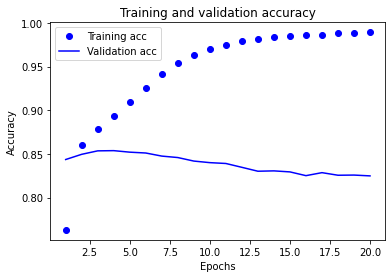

In [39]:
# accuracy 그래프로 그려보기
plt.clf() # 그림 초기화

plt.plot(epochs, acc2, 'bo', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 7. 학습된 Embedding 레이어 분석

In [40]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [41]:
# 학습된 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
 # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
# Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.00904192,  0.03691669,  0.00371656,  0.00583135,  0.02162929,
        0.00208775,  0.13356102,  0.06105204,  0.01465241,  0.05145414,
        0.04984772, -0.0504699 , -0.04117066,  0.01685152, -0.03031204,
        0.04349237], dtype=float32)

In [43]:
# '배우'와 유사한 단어 찾아보기
word_vectors.similar_by_word('배우')

[('이럴', 0.7292705774307251),
 ('성경', 0.7045276165008545),
 ('긋', 0.6922020316123962),
 ('안감', 0.6891361474990845),
 ('들어왔', 0.6839130520820618),
 ('캐릭터', 0.6786627173423767),
 ('미군', 0.670450747013092),
 ('어쩌다가', 0.6692837476730347),
 ('이랑', 0.6547607183456421),
 ('똥폼', 0.6454204320907593)]

## Step 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [45]:
# Word2vec 모델 가져오기
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [46]:
# '배우'와 유사한 단어 찾아보기
word_vectors.wv.similar_by_word("배우")

[('가수', 0.7729029655456543),
 ('코미디언', 0.7728644609451294),
 ('만화가', 0.749615490436554),
 ('영화배우', 0.7441834211349487),
 ('여배우', 0.7411354184150696),
 ('연출가', 0.7396705746650696),
 ('극작가', 0.7209770679473877),
 ('삽화가', 0.7152643799781799),
 ('안무가', 0.7149248123168945),
 ('무용가', 0.7118033766746521)]

In [47]:
# 학습했던 모델의 임베딩 레이어를 word_vectors의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [48]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [49]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.5145 - accuracy: 0.7392 - val_loss: 0.4188 - val_accuracy: 0.8103
Epoch 2/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3810 - accuracy: 0.8320 - val_loss: 0.3705 - val_accuracy: 0.8347
Epoch 3/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3356 - accuracy: 0.8558 - val_loss: 0.3508 - val_accuracy: 0.8437
Epoch 4/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3088 - accuracy: 0.8693 - val_loss: 0.3442 - val_accuracy: 0.8475
Epoch 5/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2898 - accuracy: 0.8796 - val_loss: 0.3425 - val_accuracy: 0.8493
Epoch 6/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2746 - accuracy: 0.8866 - val_loss: 0.3547 - val_accuracy: 0.8445
Epoch 7/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2603 - accuracy: 0.8943 - val_loss: 0.3606 - val_accuracy:

In [50]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5799 - accuracy: 0.8349
[0.579856812953949, 0.8349167108535767]


------

## (3) GlobalMaxPooling 모델

## Step 4. 모델 구성 및 validation set 구성

In [51]:
# GlobalMaxPooling1D() 레이어 하나만 사용
vocal_size = 10000 # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16 # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [52]:
# validation set 30000건 분리
X_val_mp = X_train[:30000]   
y_val_mp = y_train[:30000]

# validation set을 제외한 나머지는 train set
partial_X_train_mp = X_train[30000:]  
partial_y_train_mp = y_train[30000:]

print(partial_X_train_mp.shape)
print(partial_y_train_mp.shape)

(116182, 41)
(116182,)


## Step 5. 모델 훈련 개시

In [53]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_mp_pre = model.fit(partial_X_train_mp,
                    partial_y_train_mp,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_mp, y_val_mp),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.6163 - accuracy: 0.7634 - val_loss: 0.4604 - val_accuracy: 0.8164
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3913 - accuracy: 0.8363 - val_loss: 0.3668 - val_accuracy: 0.8379
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3341 - accuracy: 0.8590 - val_loss: 0.3542 - val_accuracy: 0.8426
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3060 - accuracy: 0.8725 - val_loss: 0.3517 - val_accuracy: 0.8452
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2853 - accuracy: 0.8822 - val_loss: 0.3549 - val_accuracy: 0.8457
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2685 - accuracy: 0.8905 - val_loss: 0.3605 - val_accuracy: 0.8465
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2541 - accuracy: 0.8976 - val_loss: 0.3679 - val_accuracy: 0.8444
Epoch 

In [54]:
# 테스트셋으로 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5170 - accuracy: 0.8272
[0.5169750452041626, 0.8271660208702087]


In [55]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict_mp_pre = history_mp_pre.history
print(history_dict_mp_pre.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Step 6. Loss, Accuracy 그래프 시각화

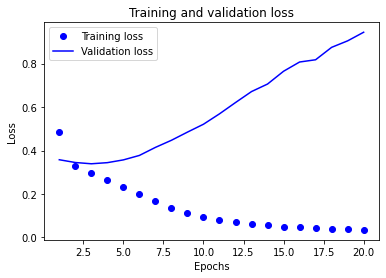

In [56]:
# loss 그래프 그리기
acc2 = history_dict_cnn_pre['accuracy']
val_acc2 = history_dict_cnn_pre['val_accuracy']
loss2 = history_dict_cnn_pre['loss']
val_loss2 = history_dict_cnn_pre['val_loss']

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, loss2, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss2, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

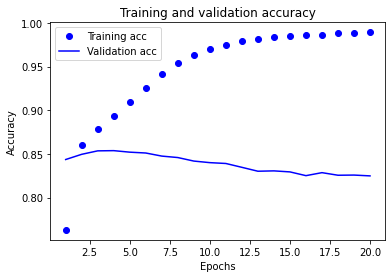

In [57]:
# accuracy 그래프로 그려보기
plt.clf() # 그림 초기화

plt.plot(epochs, acc2, 'bo', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 7. 학습된 Embedding 레이어 분석

In [58]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [59]:
# 학습된 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
 # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [60]:
# Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.25151297, -0.2558891 , -0.178277  , -0.23762211, -0.20607823,
       -0.27258015, -0.29830647, -0.22582655, -0.25149718, -0.26326573,
       -0.21045947, -0.27016303, -0.26189798, -0.02091313, -0.28733972,
       -0.20674996], dtype=float32)

In [61]:
# '배우'와 유사한 단어 찾아보기
word_vectors.similar_by_word('배우')

[('만드', 0.9843126535415649),
 ('..', 0.9776294231414795),
 ('내', 0.9632648825645447),
 ('씨', 0.9544117450714111),
 ('...', 0.9542429447174072),
 ('이완', 0.9531119465827942),
 ('파이터', 0.9525415897369385),
 ('그런지', 0.9517053961753845),
 ('영화', 0.950676441192627),
 ('스럽', 0.9506231546401978)]

## Step 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [62]:
# Word2vec 모델 가져오기
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [63]:
# '배우'와 유사한 단어 찾아보기
word_vectors.wv.similar_by_word("배우")

[('가수', 0.7729029655456543),
 ('코미디언', 0.7728644609451294),
 ('만화가', 0.749615490436554),
 ('영화배우', 0.7441834211349487),
 ('여배우', 0.7411354184150696),
 ('연출가', 0.7396705746650696),
 ('극작가', 0.7209770679473877),
 ('삽화가', 0.7152643799781799),
 ('안무가', 0.7149248123168945),
 ('무용가', 0.7118033766746521)]

In [64]:
# 학습했던 모델의 임베딩 레이어를 word_vectors의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [65]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [66]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.5131 - accuracy: 0.7408 - val_loss: 0.4222 - val_accuracy: 0.8064
Epoch 2/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3784 - accuracy: 0.8324 - val_loss: 0.3613 - val_accuracy: 0.8385
Epoch 3/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3319 - accuracy: 0.8561 - val_loss: 0.3494 - val_accuracy: 0.8428
Epoch 4/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.3047 - accuracy: 0.8705 - val_loss: 0.3424 - val_accuracy: 0.8480
Epoch 5/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2860 - accuracy: 0.8809 - val_loss: 0.3463 - val_accuracy: 0.8483
Epoch 6/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2697 - accuracy: 0.8887 - val_loss: 0.3497 - val_accuracy: 0.8477
Epoch 7/20
1025/1025 [==============================] - 5s 5ms/step - loss: 0.2554 - accuracy: 0.8961 - val_loss: 0.3497 - val_accuracy:

In [67]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6220 - accuracy: 0.8340
[0.6219927668571472, 0.8340012431144714]


-------

## 회고
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였는가?  
RNN, CNN, MaxPooling 3가지 모델로 text classification을 해보았고, accuracy는 세가지 모델이 비슷하게 나왔다.  
2. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석 하였는가?  
세 가지 모델 모두 자체학습한 임베딩으로 gensim의 유사단어 찾기를 활용했을 때, 유사도가 많이 떨어졌다고 느껴졌다. 이에 비해 사전학습 임제딩으로 gensim의 유사단어 찾기를 활용했을 때에는 확실히 유사도가 올라갔음을 느꼈다.  
3. 한국어 Word2Vec을 활용하여 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성하였는가?  
한국어 Word2Vec을 활용하기 위해 많은 시행착오를 겪었지만 여러 시도 끝에 문제를 해결하였다. 그렇게 한국어 Word2Vec을 활용했는데 안타깝게도 정확도가 85%를 넘지 못했다. convolution layer나 epoch, batch_size의 값을 조정해봤지만 오히려 정확도가 떨어질 뿐이었다. 성능향상을 위해서 다른 방법을 더 찾아보도록 해야겠다.  
4. 프로젝트를 진행하면서 느낀점 : 이번 프로젝트는 유난히 어려웠다. 에러 하나를 해결하면 또다른 에러가 발생했다. 그 외에도 전체적으로 내용이 너무 어려웠다. lms를 많이 참고했음에도 이해가 안되는 부분도 많았고, 해결하지 못한 문제도 많았다. 그럼에도 불구하고 프로젝트를 완성은 했다는 점이 뿌듯하기도 했고, 내가 부족한 부분을 더 보충해야겠다는 생각이 더욱 들기도 했다.

## Reference
[drop_duplicates](https://wikidocs.net/154060)  
[tokenizer.morphs](https://han-py.tistory.com/283)  
[np.concatenate](https://cosmosproject.tistory.com/254)  
[tolist()](https://cosmosproject.tistory.com/410)  
[ko.bin](https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c)